cloning the github repo cotaining the dataset

Dataset source : https://github.com/mshunshin/SegNetCMR/tree/master/Data

In [ ]:
!git clone https://github.com/mehdi-nait/Heart-Failure-Symptomes-detection.git

In [97]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import Augmentor
!pip install dropblock
from dropblock import DropBlock2D

#!pip install wandb
#import wandb


In [98]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Constructing Dataset class

## Data Augmentation using Augmentor 

In [75]:
def augment_dataset(images_path,labels_path,num_samples):
    """
    Performs data augmentation on the image dataset using geometrical transformations
    
    Inputs
    --------
    images_path: (Str)
       path to the images folder
    labels_path: (Str)
       path to the corrsponding labels folder
    num_samples: (int)
       number of generated samples
    """
    
    images = os.listdir(images_path)
    labels = os.listdir(labels_path)
    
    #num_samples check
    if(num_samples<=len(images)):
        print("The number of requested samples should be greater than the length of the dataset!")
        return
    
    print(f"initial dataset size : {len(images)}")
    
    images = [images_path+X for X in images]
    labels = [labels_path+X for X in labels]
    
    collected = list(zip(images,labels))
    
    images = [[np.asarray(Image.open(y)) for y in x] for x in collected]
    
    p = Augmentor.DataPipeline(images)
    
    p.random_distortion(0.8,grid_height=15,grid_width=15,magnitude=5)
    p.rotate(1, max_left_rotation=5, max_right_rotation=5)
    p.flip_top_bottom(0.5)
    p.zoom_random(0.5, percentage_area=0.7)
    
    augmented_images= p.sample(num_samples)
    
    for i in range(len(augmented_images)):
      
      cv2.imwrite(f"{images_path}{i}.png", augmented_images[i][0])
      cv2.imwrite(f"{labels_path}{i}.png", augmented_images[i][1])
    
    
    print(f"Augmentation finished, current dataset size : {len(os.listdir(images_path))}")

In [100]:
#Data augmentation

images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

NUM_SAMPLES = 3000

augment_dataset(images_path,labels_path,NUM_SAMPLES)

The number of requested samples should be greater than the length of the dataset!


In [101]:
#Comparing the number of datapoints

images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(f"The given folder contains {len(images)} images")
print(f"The given folder contains {len(labels)} labels")


The given folder contains 3526 images
The given folder contains 3526 labels


## Dataset class

In [102]:
class Dataset_seg(Dataset):
    """A class used to represent the dataset
    
    Attributes
    ----------

    images : list(str)
        a list of image paths 
    labels : list(str)
        list of labels paths
    size_img : tuple(int,int)
        image and label size
    transform : function
        transformation to be applied on the images/labels
    
    Methods
    -------
    __init__(self,image_dir,label_dir,transform = None)
        instanciates the dataset object
    __len__(self)
        returns the length of the dataset
    __getitem__(self,idx)
        returns a image,label matrices couple after transforamations

    """
    
    def __init__(self,image_dir,label_dir,transform = None):

        
        self.images = os.listdir(image_dir)
        self.images = [image_dir+x for x in self.images]
        
        self.labels = os.listdir(label_dir)
        self.labels = [label_dir+x for x in self.labels]
        self.transform = transform
        self.size_img = (256,256)
        
    def __len__(self):

        return len(self.images)
    
    def __getitem__(self,idx):

        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image,self.size_img)
        label = cv2.resize(label,self.size_img)
        
        image = cv2.equalizeHist(image)
        label = cv2.equalizeHist(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = image.to(device)
        label = label.to(device)
        return image,label
        
        

# Building U-Net Model

Inspired from O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical 
image segmentation,” 

![plot](U-net.png)


In [83]:
# Testing dropblock layer implementation

#image = cv2.imread("U-net.png",cv2.IMREAD_GRAYSCALE)
#drop = DropBlock2D(0.5,30)

#cv2.resize(image,(500,500))

#plt.imshow(image,cmap="gray")
#print(image.shape)

#to = transforms.ToTensor()
#image = to(image)
#image = torch.unsqueeze(image,0)

#out = drop(image)

#out = out.numpy().squeeze()

#plt.imshow(out,cmap="gray")



In [103]:
class Block(nn.Module):
  """
  Backbone of the U-Net model: a two CBR (Conv, BatchNorm, LeakyRelu) blocks, a drop-out layer can be added to enhance precision
  
  Attributes
  ------------
  
  in_channels: (int)
      the number of channels of the input image
  out_channels: (int)
      the number of channels of the computed output image
  """

  def __init__(self,in_channels,out_channels):
    
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3)
    self.relu  = nn.LeakyReLU()
    self.dropBlock = DropBlock2D(0.5,6)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3)
    

  def forward(self,x):
    
    x = self.conv1(x)
    #x = self.dropBlock(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    x = self.conv2(x)
    #x = self.dropBlock(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    return x

In [104]:
class Encoder(nn.Module):
    """
    Compression path of the U-Net
    
    Attributes
    ----------
    
    channels : Tuple(int)
        tuple of the output channels scheme of the path
    """

    def __init__(self,channels = (1,16,32,64)):
        super(Encoder,self).__init__()
        
        # create a module list of the U-Net backbones
        
        self.encode_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
        self.pooling = nn.MaxPool2d(2,2)

    def forward(self,x):

        outputs = []
        #performs compression path image computation, and stores the outputs in a vector to be fed to the upsampling path
        for block in self.encode_blocks:
            x = block(x)
            outputs.append(x)
            x = self.pooling(x)
        return outputs

In [105]:
class Decoder(nn.Module):
    """
    The upsampling path of the U-Net
    
    Attributes
    ----------
    
    channels: Tuple(int) 
        a tuple conataining the number of output channels of each block, must be the reverse tuple of the compressing block
        because of the data passing between the compression and upsampling blocks
    """
    def __init__(self,channels = (64,32,16)):

        super(Decoder,self).__init__()

        self.channels = channels
        #self.drop_out = nn.Dropout2d(p=0.5)
        self.up_convs  = nn.ModuleList(nn.ConvTranspose2d(channels[i],channels[i+1],2,2) for i in range(len(channels)-1))
        self.dec_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
        self.batch_norms = nn.ModuleList(nn.BatchNorm2d(channels[i+1]) for i in range(len(channels)-1))

    def forward(self,x,enc_features):

        for i in range(len(self.channels)-1):
      
            x = self.up_convs[i](x)
            #x = self.drop_out(x)
            x = self.batch_norms[i](x)
            enc_feature = self.copy_crop(enc_features[i],x)
            x = torch.cat((enc_feature,x),dim=1)
            x = self.dec_blocks[i](x)
        
        return x


    def copy_crop(self,feature,x):
        """
        Performs a center crop of the compression path features to match the upsampling path features
        """
        _,_,H,W = x.shape
        cropped_feature = transforms.CenterCrop([H,W])(feature)
        return cropped_feature

In [106]:
class Unet(nn.Module):
    """
    U-Net class, assembling the compression and the upsampling blocks
    
    Attributes
    ----------
    
    enc_channels: Tuple(int)
        Tuple of compression path channels, to be used to initialize the Encoder block
    dec_channels: Tuple(int)
        Tuple of decompression path channels, to be used to initilize the Decoder block
    nb_classes  : (int)
        Number of segmentation classes
    retainDim   : (boolean)
        A flag that indicates if a given output size should be respected
    out_size    : Tuple(int)
        Desired size of the output images
    """

    def __init__(self, enc_channels = (1,16,32,64), dec_channels = (64,32,16),nb_classes = 1, retainDim = True, out_size=(256,256)):
        super(Unet,self).__init__()
        
        self.encoder = Encoder(enc_channels)
        self.decoder = Decoder(dec_channels)
        
        self.head = nn.Conv2d(dec_channels[-1], nb_classes, 1)
        self.retainDim = retainDim
        self.outSize = out_size
        self.activation = nn.Sigmoid()
      
    
    def forward(self,x):
        enc_features = self.encoder(x)
        dec_features = self.decoder(enc_features[::-1][0],enc_features[::-1][1:])
          
        map = self.head(dec_features)
        map = self.activation(map)
        
        if self.retainDim:
          map = F.interpolate(map, self.outSize)
        
    
        return map

# Defining training metrics (loss & accuracy mesurement)

Here, we're using a Sigmoid Binary Cross Entropy loss function combined with dice loss, which yielded better results for dataset

In [107]:
class SoftDiceLoss(nn.Module):
    """
    Implementation of the Dice loss function
    
    """
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score
    

In [108]:
class BCE_DiceLoss(nn.Module):
    """
    Implementation of Binary cross entropy coupeled with Dice loss
    """
    def __init__(self,weight = None,size_average = True):
        super(BCE_DiceLoss,self).__init__()
      
    def forward(self,logits,targets):
        bce = nn.BCEWithLogitsLoss()
        dice_loss = SoftDiceLoss()
        return bce(logits, targets) + (1-dice_metric(logits, targets))
    

Defining accuracy mesurement metrics, namely Dice coefficient and jaccard's index (Intersection over Union)

In [109]:
def dice_metric(output,label):
    """
    Computes Dice coeffecient of the output and the ground truth
    
    Inputs
    ----------
    output: Tensor(float)
        output of the neural network in tensor form
    label : Tensor(float)
        ground truth label in tensor shape, must be the same shape as the output
        
    Outputs
    ---------
    dice_coeff : (float)
        Dice coeffient output: (2*intersection)/union
    """
    intersection = 2.0* (output*label).sum()
    union = output.sum()+label.sum()

    if output.sum()==0 and label.sum()==0:
        return  1
    dice_coeff = intersection/union
    
    return dice_coeff

In [110]:
def IoU_metric(output,label):
    """
    Computes Intersection over union accuracy metric
    
    Inputs
    ----------
    output: Tensor(float)
        output of the neural network in tensor form
    label : Tensor(float)
        ground truth label in tensor shape, must be the same shape as the output
        
    Outputs
    ---------
    IoU : (float)
        Intersection over union (IoU) coeffient output: intersection/union
    """
    
    intersection = (output*label).sum()
    union = output.sum()+label.sum() - intersection

    if output.sum()==0 and label.sum()==0:
        return  1
    
    IoU = intersection/union
    
    return IoU

# Data preparation, and model training

In [111]:
EPOCHS = 1
BATCH_SIZE = 20
LR = 0.001
MOMENTUM = 0.99
ENC_CHANNELS = (1,32,64,128,256) #ENC_CHANNELS = (1,16,32,64,128)
DEC_CHANNELS = (256,128,64,32) #DEC_CHANNELS = (128,64,32,16)

In [112]:
train_dir = "Data/Dataset/Train/"
valid_dir = "Data/Dataset/Test/"
test_dir = "Data/Dataset2/manual_contours/"


train_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
valid_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())
test_dataset  = Dataset_seg(test_dir+"/images/",test_dir+"/contours/",transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader  = DataLoader(test_dataset, batch_size = 1, shuffle = True)




In [113]:
config = {
  "Loss_function" : "BCE_DiceLoss",
  "Optimizer" : "SGD",
  "Learning_rate": LR,
  "Momentum":MOMENTUM,
  "Image_Size" : 256,
  "encoder layers":ENC_CHANNELS,
  "decoder layers":DEC_CHANNELS,
  "Epochs": EPOCHS,
  "Batch_size": BATCH_SIZE,
  "Device" : device
}

#wandb.init(config=wandb.config,project="U-Net", entity="mehdi-nait")


In [114]:
model = Unet(enc_channels=ENC_CHANNELS, dec_channels=DEC_CHANNELS)
loss_function = BCE_DiceLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
# initialize a dictionary to store training history
H = {"train_loss": [], "valid_loss": [], "train_dice": [], "train_IoU": [], "valid_dice": [], "valid_IoU": []}

In [115]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

1926881

## Training loop

In [116]:
NUM_EPOCHS = config["Epochs"]

print("[INFO] training in progress ...")

start_time = time.time()

model = model.to(device)

for e in tqdm(range(NUM_EPOCHS)):

  model.train()

  total_train_loss = 0
  total_valid_loss = 0

  total_train_dice = 0
  total_valid_dice = 0

  total_train_IoU = 0
  total_valid_IoU = 0

  for (i, (x, y)) in enumerate(train_dataloader):
    
    optimizer.zero_grad()
    (x,y) = (x.to(device),y.to(device))

    pred = model(x)
    

    loss = loss_function(pred,y)
    
    loss.backward()

    optimizer.step()
    #pred = nn.Sigmoid()(pred)
    total_train_loss += loss.item()
    total_train_dice += dice_metric(pred,y).item()
    total_train_IoU  += IoU_metric(pred,y).item()

  with torch.no_grad():

    #model.eval()

    for (i, (x, y)) in enumerate(valid_dataloader):

      pred = model(x)

      total_valid_loss += loss_function(pred, y).item()
      #pred = nn.Sigmoid()(pred)
      total_valid_dice += dice_metric(pred,y).item()
      total_valid_IoU  += IoU_metric(pred,y).item()

  train_loss = total_train_loss / len(train_dataloader)
  valid_loss = total_valid_loss / len(valid_dataloader)

  train_dice = total_train_dice / len(train_dataloader)
  valid_dice = total_valid_dice / len(valid_dataloader)

  train_IoU  = total_train_IoU / len(train_dataloader)
  valid_IoU  = total_valid_IoU / len(valid_dataloader)


  H["train_loss"].append(train_loss)
  H["valid_loss"].append(valid_loss)

  H["train_dice"].append(train_dice)
  H["valid_dice"].append(valid_dice)

  H["train_IoU"].append(train_IoU)
  H["valid_IoU"].append(valid_IoU)
    
  ######################################################################
  #img,label = next(iter(test_dataloader))
#
  #model = model.to(device)
  #img = img.to(device)
  #output = model.forward(img)
  #
  #
  #img = img.cpu().squeeze()
  #output = output.cpu().detach().numpy().squeeze()
  #label = label.cpu().squeeze()
#
  #fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
#
  #ax1.imshow(img)
  #ax2.imshow(output)
  #ax3.imshow(label)
  ##fig.colorbar()
  #fig.show()
  
  ######################################################################

  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Valid loss: {:.4f}, Train DICE: {:.4f}, Valid DICE: {:.4f}, Train IoU: {:.4f}, Valid IoU: {:.4f}".format(
      train_loss, valid_loss,train_dice,valid_dice,train_IoU,valid_IoU))
  
end_time = time.time()

print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))

[INFO] training in progress ...


100%|██████████| 1/1 [19:08<00:00, 1148.52s/it]

[INFO] EPOCH: 1/1
Train loss: 1.693587, Valid loss: 1.6136, Train DICE: 0.1743, Valid DICE: 0.1705, Train IoU: 0.0972, Valid IoU: 0.0936
[INFO] total time taken to train the model: 1148.53s


In [ ]:
plt.plot(H["train_loss"],'r', label='Training Loss')
plt.plot(H["valid_loss"],'b', label='Validation Loss')
plt.legend()
plt.show()

plt.plot(H["train_dice"],'r', label='Training Dice')
plt.plot(H["valid_dice"],'b', label='Validation Dice')
plt.title("Dice evolution during training/validation")
plt.legend()
plt.show()

plt.plot( H["train_IoU"], 'r', label='Training IoU')
plt.plot(H["valid_IoU"], 'b', label='Validation IoU')
plt.title("IoU evolution during training/validation")
plt.legend()
plt.show()

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [ ]:
model.train()

dice = 0
IoU = 0
model = model.to(device)
for i,(img,label) in enumerate(test_dataloader):
    
    img = img.to(device)
    output = model.forward(img)
    dice += dice_metric(output,label).item()
    IoU += IoU_metric(output,label).item()
    
print(f"Dice_metric avg : {(dice/len(test_dataloader))*100}% , IoU {(IoU/len(test_dataloader))*100:.3f}%")

In [21]:
test_dir = "Data/Dataset2/manual_contours/images/"
#test_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
test_dataset = Dataset_seg(test_dir,valid_dir+"/Labels/",transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

Dice_metric : 4.752% , IoU 2.434%


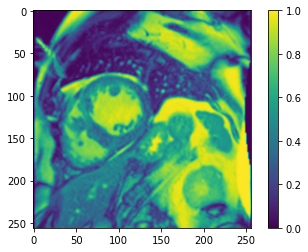

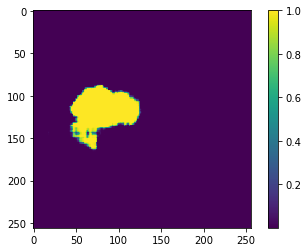

In [28]:
model.train()

img,label = next(iter(test_dataloader))

model = model.to(device)
img = img.to(device)
output = model.forward(img)

print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")

img = img.cpu().squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

output = output.cpu().detach().numpy().squeeze()
plt.imshow(output)
plt.colorbar()
plt.show()


#label = label.cpu().squeeze()
#plt.imshow(label)
#plt.colorbar()

plt.show()


#img = wandb.Image(img, caption="Input image")
#label = wandb.Image(label, caption="Mask image")
#output = wandb.Image(output, caption="U-Net output")
          
#wandb.log({"Input": img, "label":label, "output":output})


# Model Saving / Loading

In [25]:
#Model saving

EPOCH = 20
PATH = "Unet_512.pt"
learning_rate = 0.001

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'learning_rate': learning_rate,
            }, PATH)

In [ ]:
PATH = "Unet.pt"

model = Unet()
model = model.to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Test zone

In [29]:
import random

In [30]:
path = "Data/Dataset2/manual_contours"
#path = "Data/Dataset2/manual_contours_ch4"
#path = "Data/Dataset/Train"


In [31]:
os.listdir(path)

['contours', 'images']

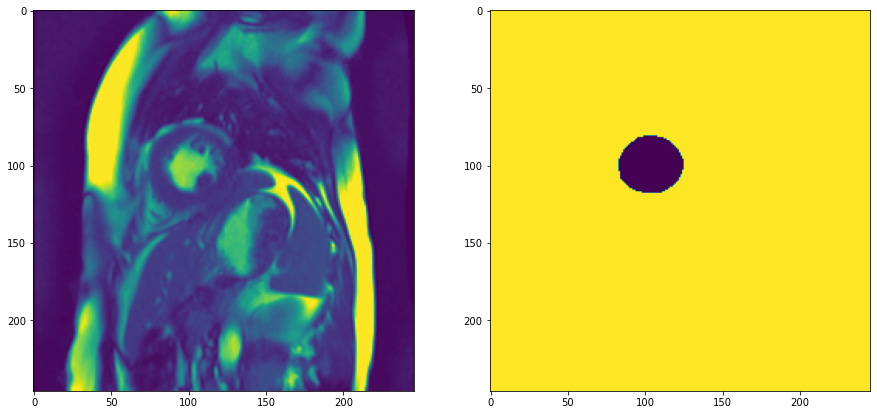

In [32]:
contours_path = path+"/contours/"
images_path = path+"/images/"

#contours_path = path+"/Labels/"
#images_path = path+"/Images/"

images = os.listdir(images_path)
contours = os.listdir(contours_path)

images = [images_path+X for X in images]
contours = [contours_path+X for X in contours]

idx = random.randint(0,len(images))

image = cv2.imread(images[idx],cv2.IMREAD_GRAYSCALE)
contour = cv2.imread(contours[idx],cv2.IMREAD_GRAYSCALE)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))

ax1.imshow(image)
ax2.imshow(contour)
fig.show()

Dice_metric : 0.000% , IoU 0.000%


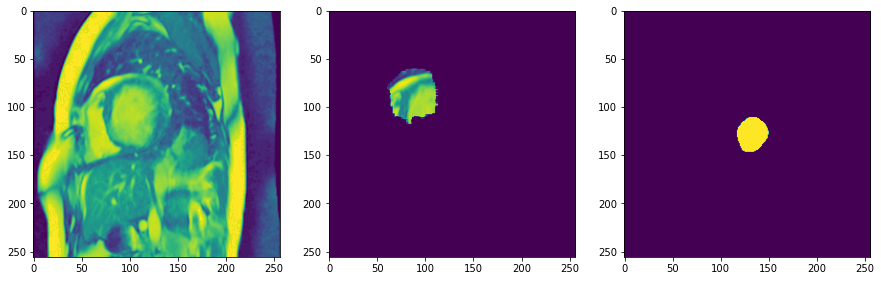

In [53]:

valid_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

img,label = next(iter(valid_dataloader))


model = model.to(device)
img = img.to(device)
label = label.to(device)
output = model.forward(img)

print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

img = img.cpu().squeeze()
label = label.cpu().squeeze()
output = output.cpu().detach().numpy().squeeze()

output = img*output


ax1.imshow(img)
ax2.imshow(output)
ax3.imshow(label)

fig.show()




In [140]:
#print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")
#label = label.numpy()
print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")

Dice_metric : 6.110% , IoU 3.151%


## Testing on a single image

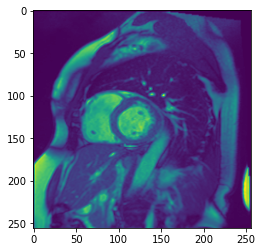

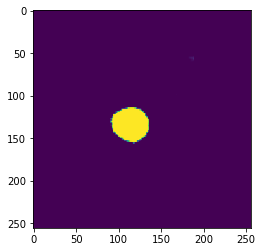

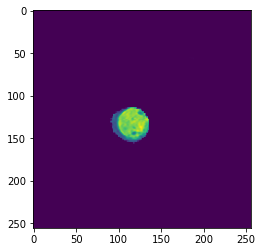

In [99]:
image = cv2.imread("systole_sax_43.png")

image = cv2.resize(image,(256,256))

image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

show_img = image.copy()

image = cv2.equalizeHist(image)

image = tr(image)

image = image.to(device)

image = torch.unsqueeze(image,dim=0) 

output = model.forward(image)


output = output.cpu().detach().numpy().squeeze()

plt.imshow(show_img)
plt.show()

plt.imshow(output)
plt.show()

plt.imshow(show_img*output)
plt.show()

# Dataset Sanity check

Data
 |___ Dataset
 |       |___ Train (Needs cleaning and augmentation strategy change) To Do ; Restore old training datasets, and follow the same file tree 
 |       |       |___ Images (3526 items)
 |       |       |___ Labels (3526 items)
 |       |___ Test
 |               |___ Images (279)
 |               |___ Labels (279)
 |       
 |___ Dataset2
         |___ manual_contours
         |           |___ images
         |           |___ contours
         |           
         |___ manual_contours_ch4
                   |___ images
                   |___ contours

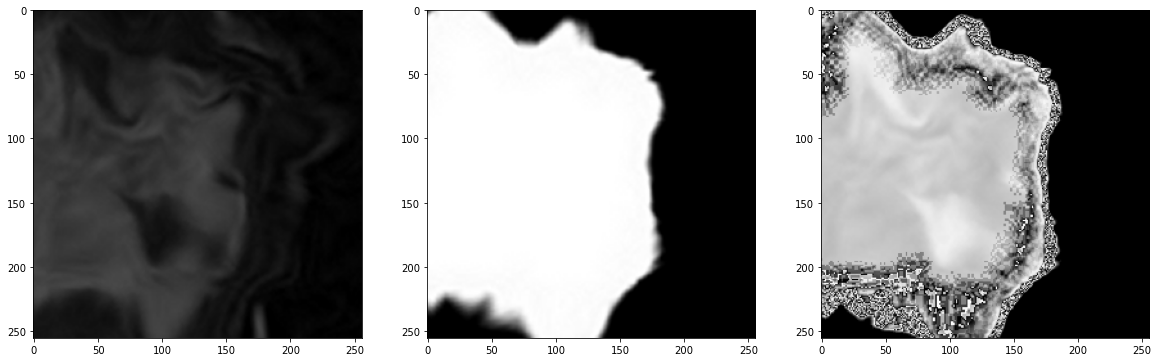

In [102]:
import cv2
import os
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)


path = "Data/Dataset/"

images = os.listdir(path+"Train/Images/")
labels = os.listdir(path+"Train/Labels/")

images = [path+"Train/Images/"+X for X in images]
labels = [path+"Train/Labels/"+X for X in labels]

idx = random.randrange(len(images))

image = cv2.imread(images[idx],cv2.COLOR_BGR2RGB)
label = cv2.imread(labels[idx],cv2.COLOR_BGR2RGB)

plt.subplot(131)
plt.imshow(image)

plt.subplot(132)
plt.imshow(label)

plt.subplot(133)
plt.imshow(label*image)

plt.show()

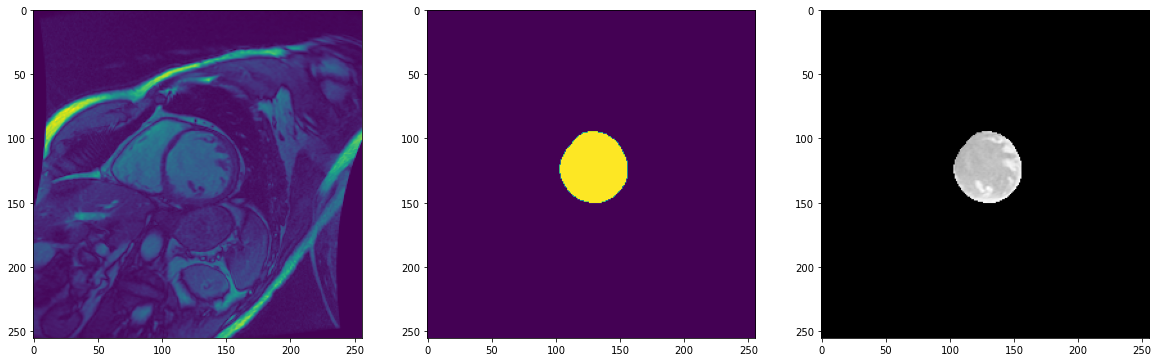

In [202]:
import cv2
import os
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)


path = "Data/Dataset/"

images = os.listdir(path+"Test/Images/")
labels = os.listdir(path+"Test/Labels/")

images = [path+"Test/Images/"+X for X in images]
labels = [path+"Test/Labels/"+X for X in labels]

idx = random.randrange(len(images))

image = cv2.imread(images[idx],0)#cv2.COLOR_BGR2RGB)
label = cv2.imread(labels[idx],0)#cv2.COLOR_BGR2RGB)

plt.subplot(131)
plt.imshow(image)

plt.subplot(132)
plt.imshow(label)

plt.subplot(133)
plt.imshow(label*image,cmap="gray")

plt.show()

In [197]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks/Heart-Failure-Symptomes-detection


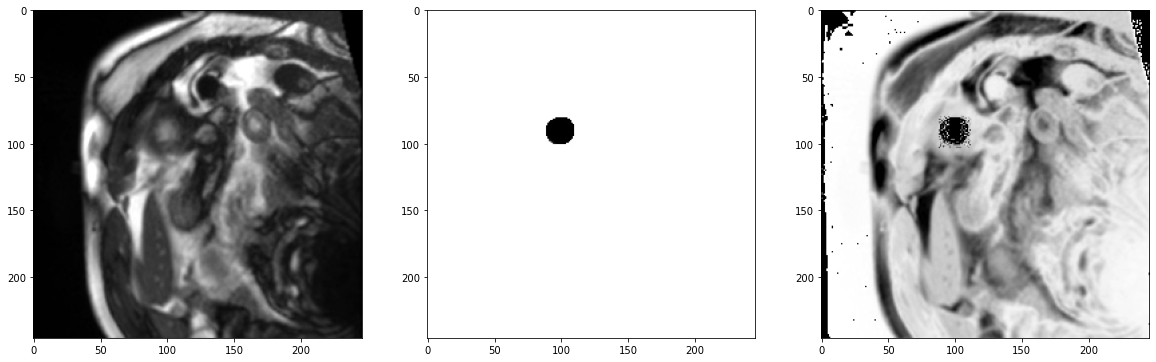

In [205]:
path = "Data/Dataset2/"

images = os.listdir(path+"manual_contours/images/")
labels = os.listdir(path+"manual_contours/contours/")

images = [path+"manual_contours/images/"+X for X in images]
labels = [path+"manual_contours/contours/"+X for X in labels]

idx = random.randrange(len(images))

image = cv2.imread(images[idx],0)
label = cv2.imread(labels[idx],0)

plt.subplot(131)
plt.imshow(image,cmap="gray")

plt.subplot(132)
plt.imshow(label,cmap="gray")

plt.subplot(133)
plt.imshow(label*image,cmap="gray")

plt.show()

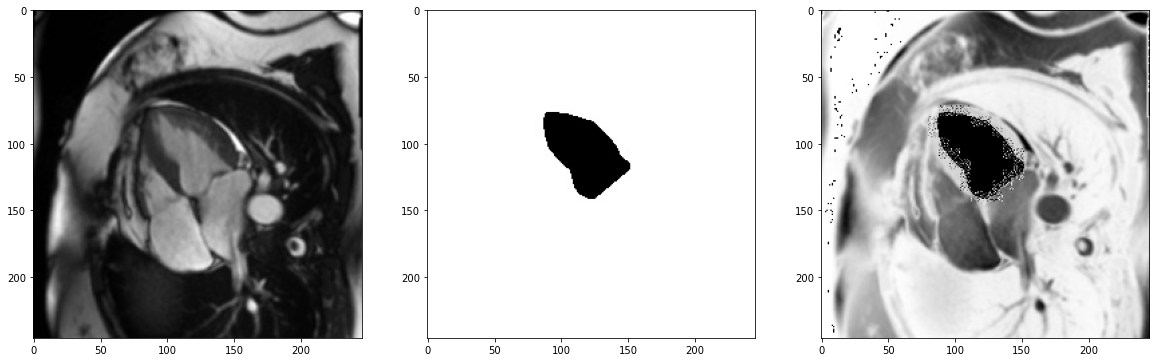

In [204]:
path = "Data/Dataset2/"

images = os.listdir(path+"manual_contours_ch4/images/")
labels = os.listdir(path+"manual_contours_ch4/contours/")

images = [path+"manual_contours_ch4/images/"+X for X in images]
labels = [path+"manual_contours_ch4/contours/"+X for X in labels]

idx = random.randrange(len(images))

image = cv2.imread(images[idx])#,cv2.COLOR_BGR2RGB)
label = cv2.imread(labels[idx])#,cv2.COLOR_BGR2RGB)

plt.subplot(131)
plt.imshow(image,cmap="gray")

plt.subplot(132)
plt.imshow(label,cmap="gray")

plt.subplot(133)
plt.imshow(label*image,cmap="gray")

plt.show()

# Data cleaning

To Do :
> - Remove augmented dataset (Dataset)
> - Fix Images reading (convert to BGR)  
> - Invert labels

In [193]:
import os
import shutil

folders = os.listdir()

for folder in folders:
    images = os.listdir(folder)
    images_abs = [folder+"/"+X for X in images]
    
    for image in images_abs:
        
    

Sunnybrook_Part1/SC-HYP-38-IM-0001-0198.dcm.png


cp: target 'Sunnybrook_Part1/SC-N-40-IM-0001-0220.dcm.png' is not a directory
